# Mappabillity Analysis of the Human Transcriptome v2

Here we try to answer the following questions:

**Which nucleotides of the transcriptome are mappable with decent confidence?**

**Which / how many genes can we map with decent confidence?**

We measure the *confidence* in terms of the mapping quality.

We try to answer the above questions for each gene, for each nucleotide position, and for the read lengths from 15 to 40.

We assume that the reads do not have any sequencing errors.

## Setup

**Reference:** Appris Human Transcriptome Version 2

**Mapq Threshold:** 10. We use `samtools view -q 10` to filter the reads mapped to the transcriptome.

**Read Length Range:** 15:40

**Read Generation:**
 For each gene, for each nucleotide position i, for each length L in 15,16,...,40, we generated reads from the nucleotide positions
 `[i:i+L]` where i is inclusive but i+L is not. Wemapped these reads to the transcriptome reference using RiboFlow.

## Summary of Findings

Shorter reads (length = 15 & 20) suffer from mappability more, compared to the reads of length 25 or longer. For example, there are only 3 genes with CDS coverage ratio >= .95 for length 15. This number is 14348 for the read length 30.

Even for longer reads, a significant number of genes (~2000) can't be mapped to cover 80% of the transcriptome. For example, for read length 35, there are 17570 genes with CDS coverage ratio >= 0.7.

We focus on coverage of the CDS region in our analysis. The entire transcriptome coverage can easily be obtained.

## Mapping Statistics

In [1]:
import pandas as pd
import numpy as np

In [2]:
stats_file = "../stats_files/appris_human_v2_stats.csv"
stats_df = pd.read_csv(stats_file, index_col=0)
stats_df.style.format({'appris_reads': '{:.1f}'})

,appris_reads
total_reads,1819421136.0
clipped_reads,1819421136.0
clipped_reads_%,100.0
filtered_out,1506916.0
filtered_out_%,0.1
filter_kept,1817914220.0
filter_kept_%,99.9
transcriptome_aligned_once,1473300405.0
transcriptome_aligned_once_%,81.0
transcriptome_aligned_many,344613815.0


In [3]:
import ribopy
from ribopy import Ribo
from ribopy.core.get_gadgets import get_region_boundaries, get_reference_names

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Some formatting forthe rest of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
ribo_path   = "../ribo/appris_human_v2.ribo"
ribo_object = Ribo(ribo_path, alias = ribopy.api.alias.apris_human_alias)
ribo_object.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.1
Creation Time     : 2020-11-23 14:31:15
Reference         : appris-v2
Min Read Length   : 15
Max Read Length   : 40
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Library:
-------- 
Name               Reads  Coverage  RNA-Seq  Metadata
appris_reads  1672891110         *                   


In [6]:
def get_coverage_at_length(ribo, experiment, length):
    return ribo.get_coverage(
                experiment  = experiment, 
                alias       = True,
                range_lower = length,
                range_upper = length)

coverage_data = dict()

length_list = list( range(15,45, 5) )

for i in length_list:
    coverage_data[i] = get_coverage_at_length(
                          ribo_object, "appris_reads", i)


In [7]:
length_list

[15, 20, 25, 30, 35, 40]

In [8]:
coverage_data[30]["GAPDH-205"]

array([1, 1, 1, ..., 0, 0, 0], dtype=uint16)

In [9]:
len(coverage_data[30])

19736

In [10]:
# Get the shortened version of the transcript names
#
ribo_object.transcript_lengths

transcript_lengths = {}

for long_name in ribo_object.transcript_lengths.keys():
    short_name = ribopy.api.alias.apris_human_alias(long_name)
    transcript_lengths[short_name] = ribo_object.transcript_lengths[long_name]


In [11]:
def find_coverage_percentages(coverage_dict):
    """
    Assumes each entry in the coverage is 0 or 1.
    It determines the raio of covered nucleotides in each transcript
    So it returns a dict of the form:
        
    """
    result = dict()
    
    for gene, coverage in coverage_dict.items():
        result[gene] = np.mean(coverage)
        
    return result
        

In [12]:
coverage_ratios     = dict()
for i in length_list:
    coverage_ratios[i] = find_coverage_percentages(coverage_data[i])

### Transcript Coverage Ratios Density for Length 30

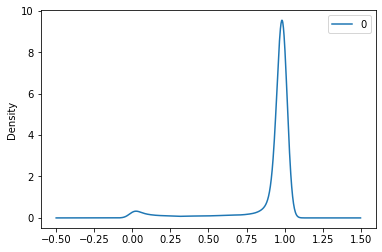

In [13]:
pd.DataFrame(  (np.add(list(coverage_ratios[30].values()), 0.0) ) ).plot(kind='density');

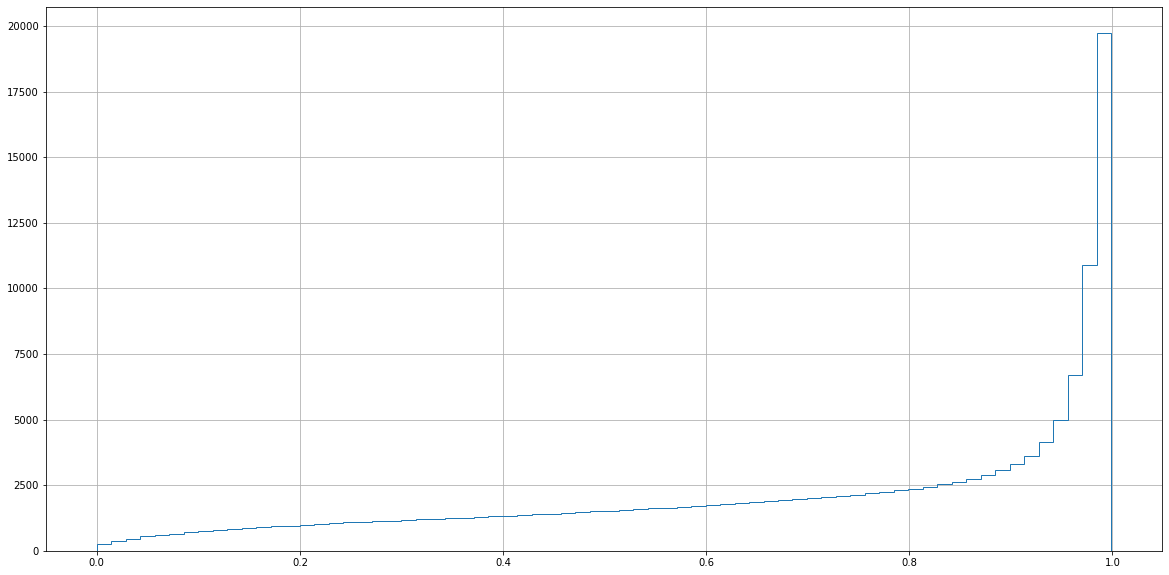

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

n, bins, patches = ax.hist(coverage_ratios[30].values(), bins = 70, density=False, histtype='step',
                           cumulative=True, label='Empirical')

ax.grid(True)

In [15]:
region_boundaries = get_region_boundaries(ribo_object._handle)
reference_names   = list(map(ribopy.api.alias.apris_human_alias , get_reference_names(ribo_object._handle) ))

In [16]:
region_boundaries[20:25]

([(0, 226), (226, 2632), (2632, 3050)],
 [(0, 115), (115, 2617), (2617, 3793)],
 [(0, 47), (47, 956), (956, 1257)],
 [(0, 52), (52, 1852), (1852, 2114)],
 [(0, 376), (376, 1018), (1018, 2154)])

In [17]:
reference_names[3000:3005]

['CTLA4-205', 'ICOS-201', 'PARD3B-204', 'NRP2-203', 'INO80D-201']

In [18]:
def get_cds_coverage_ratios(reference_names, region_boundaries, coverage_data):
    """
    To be completed!!!
    """
    result               = dict()
    names_and_boundaries = zip(reference_names, region_boundaries)
    
    for gene, boundaries in names_and_boundaries:
        gene_coverage_vector = coverage_data[gene]
        cds_start            = boundaries[1][0]
        cds_end              = boundaries[1][1]
        cds_length           = cds_end - cds_start
        total_cds_coverage   = np.sum(gene_coverage_vector[cds_start:cds_end]) 
        cds_coverage_ratio   = total_cds_coverage / cds_length
        result[gene]         = cds_coverage_ratio
        
    return result

In [19]:
cds_ratios = dict()

for i in length_list:
    cds_ratios[i] = get_cds_coverage_ratios(reference_names, 
                        region_boundaries, 
                        coverage_data[i])

Text(0, 0.5, 'Number of genes with ratio <= x ')

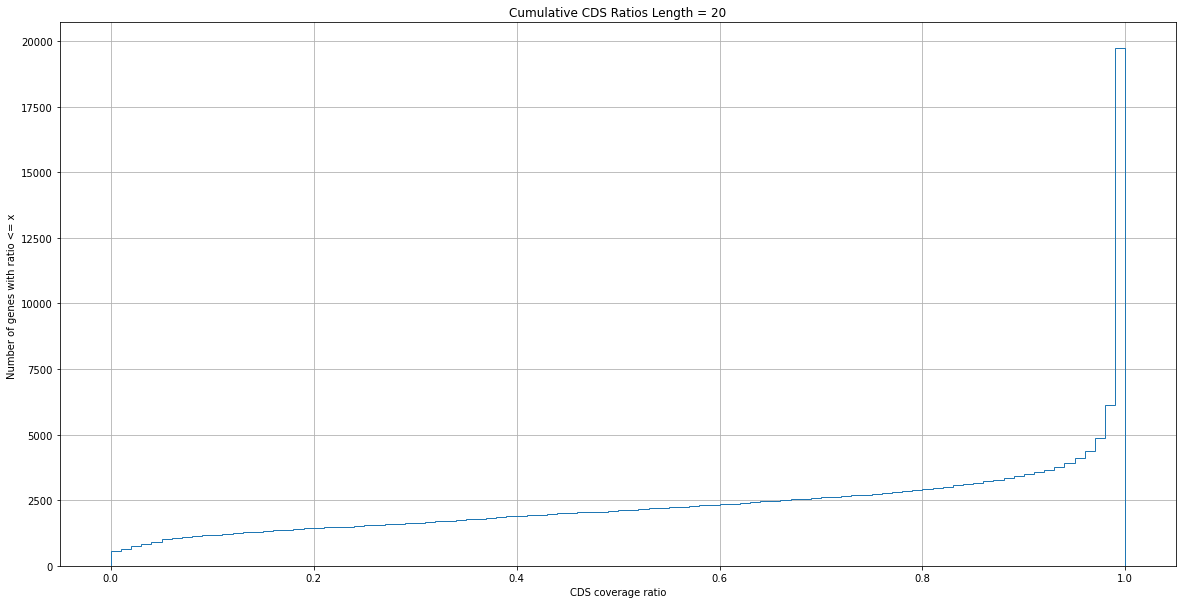

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Cumulative CDS Ratios Length = 20')

n, bins, patches = ax.hist(cds_ratios[20].values(), 
                           bins       = 100, 
                           density    = False, 
                           histtype   = 'step',
                           cumulative = True, 
                           label      = 'Empirical')
ax.grid(True)

ax.set_xlabel('CDS coverage ratio')
ax.set_ylabel('Number of genes with ratio <= x ')

Text(0, 0.5, 'Number of genes with ratio <= x ')

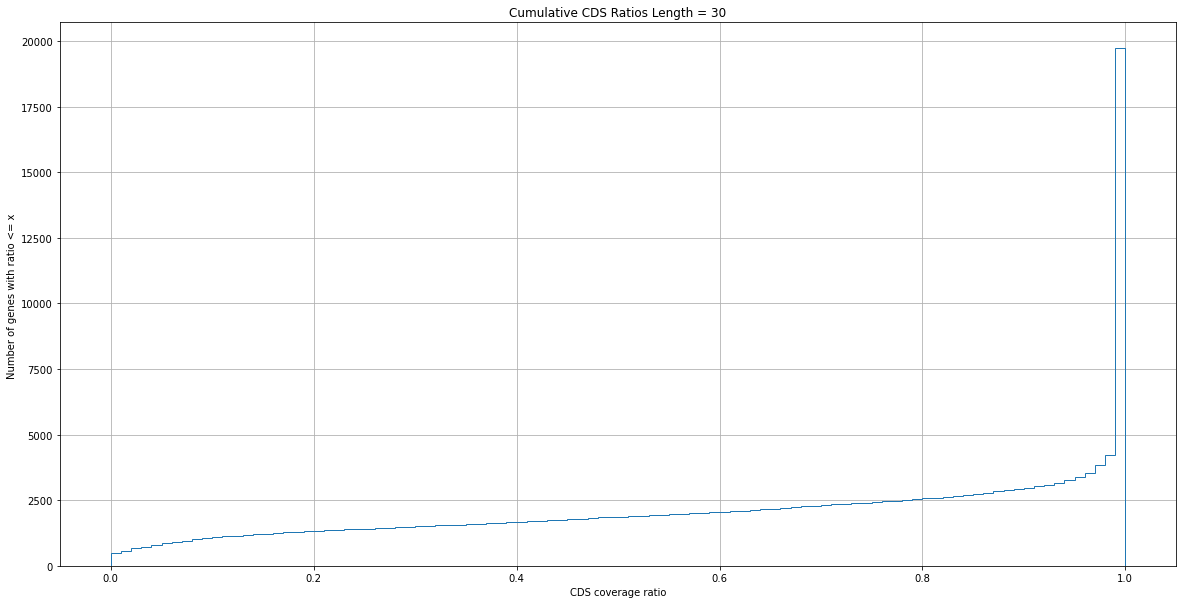

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Cumulative CDS Ratios Length = 30')

n, bins, patches = ax.hist(cds_ratios[30].values(), 
                           bins       = 100, 
                           density    = False, 
                           histtype   = 'step',
                           cumulative = True, 
                           label      = 'Empirical')
ax.grid(True)

ax.set_xlabel('CDS coverage ratio')
ax.set_ylabel('Number of genes with ratio <= x ')

In [22]:
def count_threshold(array, threshold):
    res = 0
    
    for i in array:
        if i >= threshold:
            res += 1
            
    return res

In [23]:
thresholds = [np.round(0.05 * i, decimals = 2) for i in range(21)]

In [24]:
type(thresholds[0])

numpy.float64

In [25]:
ratio_threshold_counts = dict()

ratio_threshold_counts["threshold"] = thresholds

for k in length_list:
    ratio_threshold_counts[str(k)] = \
        [ count_threshold(cds_ratios[k].values(), i) for i in thresholds ]


 ## CDS Coverage
 
The numbers 15, 20, 25, 30, 35 indicate the read lengths
Except for the "threshold column", the number of genes
whose cds coverage ratio is >= threshold is given in each entry.

In [26]:
pd.DataFrame(data = ratio_threshold_counts)

,threshold,15,20,25,30,35,40
0,0.00,19736,19736,19736,19736,19736,19736
1,0.05,18650,18810,18885,18939,18979,19021
2,0.10,18441,18573,18631,18672,18740,18783
3,0.15,18267,18434,18486,18535,18576,18609
4,0.20,18101,18311,18374,18424,18461,18496
5,0.25,17935,18217,18288,18338,18376,18408
6,0.30,17758,18117,18198,18244,18291,18330
7,0.35,17631,17990,18100,18169,18211,18251
8,0.40,17496,17855,17993,18080,18133,18173
9,0.45,17327,17740,17891,17974,18047,18095
